[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/fig_1.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/fig_1.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/fig_1.ipynb)

Asian-option pricing using 2D advection-diffusion solver   
MSc project by Paweł Magnuszewski (pmagnus@student.agh.edu.pl)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1"

In [3]:
from functools import lru_cache

import numba
import numpy as np
from matplotlib import pyplot
from pystrict import strict
from ipywidgets import IntProgress

from open_atmos_jupyter_utils import show_plot, show_anim

from PyMPDATA import Options, ScalarField, Solver, Stepper, VectorField
from PyMPDATA.boundary_conditions import Extrapolated
from PyMPDATA.impl.traversals_common import make_fill_halos_loop
from PyMPDATA.impl.enumerations import SIGN_LEFT, ARG_FOCUS, META_AND_DATA_META, META_AND_DATA_DATA, OUTER, INNER
import PyMPDATA_examples.utils.financial_formulae.asian_option as asian_analytic
from PyMPDATA_examples.utils.financial_formulae import Black_Scholes_1973 

In [4]:
OPTIONS = {
    "n_iters": 3,
    "infinite_gauge": False,
    "nonoscillatory": True,
    "divergent_flow": False,
    "third_order_terms": False,
    "non_zero_mu_coeff": True,
}

In [5]:
@strict
class Settings:
    T = 2.5
    S_min = 4
    S_max = 400
    sigma = 0.6
    r = 0.008
    K1 = 75

    S_match = K1-1
    l2_opt = 2
    C_opt = 0.05
    
    def terminal_value(self, A: np.ndarray):
        """ A is a 1d array, the payoff is the max of the average price minus the strike price
        however, we need to transform it into a 2d array, that is square """
        payoff = np.maximum(0, A - self.K1)
        payoff = np.repeat([payoff], payoff.shape[0], axis=0)
        return np.exp(-self.r * self.T) * payoff

In [6]:
@lru_cache()
# pylint: disable=too-many-arguments
def _make_scalar_extrapolated(dim, eps, ats, set_value, halo, dtype, jit_flags, data):
    @numba.njit(**jit_flags)
    def impl(focus_psi, span, sign):
        if sign == SIGN_LEFT:
            i = focus_psi[0][INNER]
            # TODO: time-dependence -> discounting
            return data[i - halo] if i >= halo and i -halo < len(data) else np.nan 

        # this is the original code from Extrapolated 
        edg = span + halo - 1 - focus_psi[ARG_FOCUS][dim]
        den = ats(*focus_psi, edg - 1) - ats(*focus_psi, edg - 2)
        nom = ats(*focus_psi, edg) - ats(*focus_psi, edg - 1)
        cnst = nom / den if abs(den) > eps else 0
        return max(
            ats(*focus_psi, -1) + (ats(*focus_psi, -1) - ats(*focus_psi, -2)) * cnst, 0
        )
    if dtype == complex:
        @numba.njit(**jit_flags)
        def fill_halos_scalar(psi, span, sign):
            return complex(
                impl(
                    (psi[META_AND_DATA_META], psi[META_AND_DATA_DATA].real), span, sign
                ),
                impl(
                    (psi[META_AND_DATA_META], psi[META_AND_DATA_DATA].imag), span, sign
                ),
            )
    else:
        @numba.njit(**jit_flags)
        def fill_halos_scalar(psi, span, sign):
            return impl(psi, span, sign)

    return make_fill_halos_loop(jit_flags, set_value, fill_halos_scalar)


class BoundaryConditionForS(Extrapolated):
    def __init__(self, data):
        super().__init__(dim=0)
        self.data = data

    def make_scalar(self, indexers, halo, dtype, jit_flags, dimension_index):
        return _make_scalar_extrapolated(
                    self.dim,
                    self.eps,
                    indexers.ats[dimension_index],
                    indexers.set,
                    halo,
                    dtype,
                    jit_flags,
                    tuple(self.data),
                )

In [7]:
class Simulation:
    def __init__(self, settings):
        sigma2 = pow(settings.sigma, 2)
        dx_opt = abs(
            settings.C_opt / (0.5 * sigma2 - settings.r) * settings.l2_opt * sigma2
        )
        dt_opt = pow(dx_opt, 2) / sigma2 / settings.l2_opt

        # adjusting dt so that nt is integer
        self.dt = settings.T
        self.nt = 0
        while self.dt > dt_opt:
            self.nt += 1
            self.dt = settings.T / self.nt

        # adjusting dx to match requested l^2
        dx = np.sqrt(settings.l2_opt * self.dt) * settings.sigma

        # arbitrary grid refinement for the second dimension advector
        multiplier = 5
        self.dt /= multiplier
        self.nt *= multiplier

        # calculating actual Courant number and lambda^2
        courant_number_x = -(0.5 * sigma2 - settings.r) * (-self.dt) / dx
        self.l2 = dx * dx / sigma2 / self.dt

        # adjusting nx and setting S_beg, S_end
        S_beg = settings.S_match
        nx = 1
        while S_beg > settings.S_min:
            nx += 1
            S_beg = np.exp(np.log(settings.S_match) - nx * dx)

        self.ix_match = nx

        S_end = settings.S_match
        while S_end < settings.S_max:
            nx += 1
            S_end = np.exp(np.log(S_beg) + (nx - 1) * dx)

        # asset price
        self.S = np.exp(np.log(S_beg) + np.arange(nx) * dx)

        dy = dx
        ny = nx

        self.mu_coeff = (0.5 / self.l2, 0)

        advectee = settings.terminal_value(A=self.S)
        
        options = Options(**OPTIONS)
        stepper = Stepper(options=options, n_dims=len(advectee.shape))

        x_dim_advector = np.full(
            (advectee.shape[0] + 1, advectee.shape[1]),
            courant_number_x,
            dtype=options.dtype,
        )
        a_dim_advector = np.zeros((nx, ny + 1))
        x = np.log(self.S)
        y = np.log(S_beg) + np.arange(ny + 1) * dx
        for i in range(ny + 1):
            a_dim_advector[:, i] = (
                ((x - (y[i] - dy / 2)) / settings.T) * -(self.dt) / dy
            )

        boundary_conditions = (BoundaryConditionForS(advectee[0,:]), Extrapolated(dim=INNER))
        self.solver = Solver(
            stepper=stepper,
            advectee=ScalarField(
                advectee.astype(dtype=options.dtype),
                halo=options.n_halo,
                boundary_conditions=boundary_conditions,
            ),
            advector=VectorField(
                (x_dim_advector, a_dim_advector),
                halo=options.n_halo,
                boundary_conditions=boundary_conditions,
            ),
        )

    def step(self):
        self.solver.advance(1, self.mu_coeff)

In [8]:
settings = Settings()
simulation = Simulation(settings)

In [9]:
def annotate_axes(ax):
    ax.set_xlabel("average asset price")
    ax.set_ylabel("underlying asset price")

In [10]:
def plot_advectee(advectee_array, t=settings.T, show=True):
    fig, ax = pyplot.subplots()
    pyplot.imshow(advectee_array, extent=(settings.S_min, settings.S_max, settings.S_min, settings.S_max), origin="lower")
    annotate_axes(ax)
    ax.set_title(f"terminal condition (advectee at t={t} years)")
    if show:
        pyplot.show()

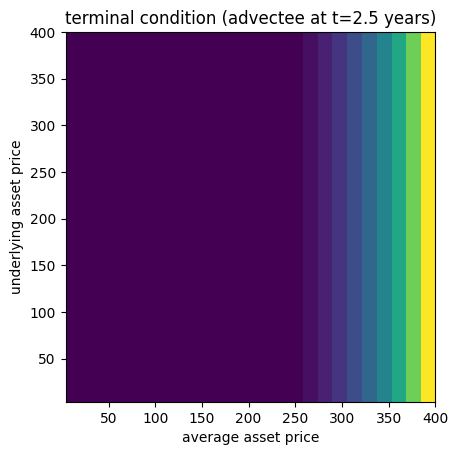

In [11]:
plot_advectee(simulation.solver.advectee.get())

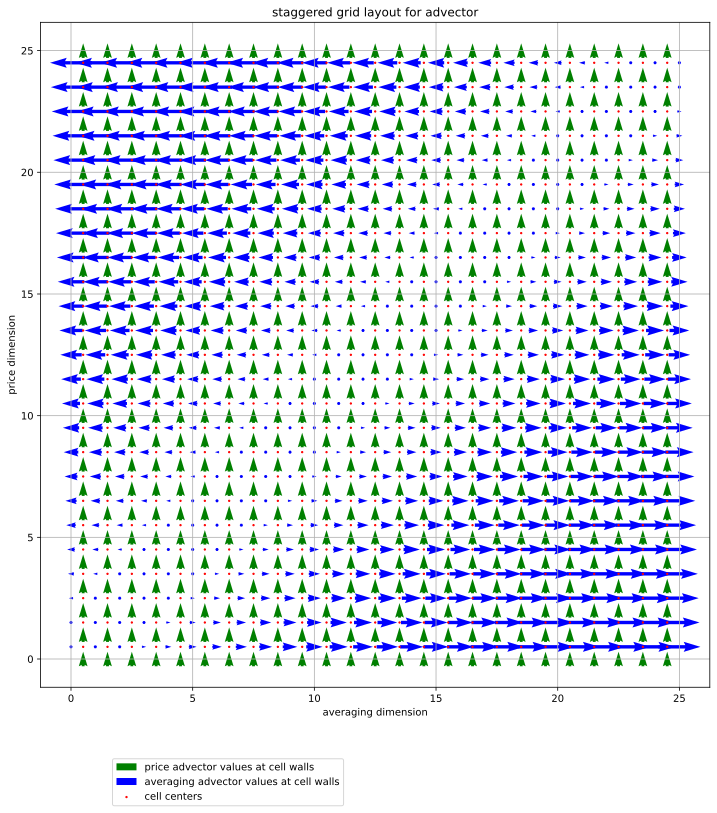

In [12]:
X = simulation.solver.advector.get_component(0)
Y = simulation.solver.advector.get_component(1)
grid = (Y.shape[0], X.shape[1])

fig, ax = pyplot.subplots(figsize=(12, 12))
ax.quiver(*np.mgrid[
        1 / 2 : grid[1] : 1,
        0: grid[0]+1 : 1,
    ], 0, X.T.flatten(), pivot='mid', color='green', width=.005,
    label='price advector values at cell walls'
)
ax.quiver(*np.mgrid[
        0: grid[1]+1 : 1,
        1 / 2 : grid[0] : 1,
    ], Y.T.flatten(), 0, pivot='mid', color='blue', width=.005,
    label='averaging advector values at cell walls'
)
ax.scatter(*np.mgrid[
        1/2: grid[1] : 1,
        1/2: grid[0] : 1
    ], color='red', label='cell centers', s=2
)

ax.axis('equal')
pyplot.title(f'staggered grid layout for advector')
pyplot.xlabel('averaging dimension')
pyplot.ylabel('price dimension')
pyplot.legend(bbox_to_anchor=(.1, -.1), loc='upper left', ncol=1)
pyplot.grid()
show_plot('advector.pdf')

In [13]:
progbar = IntProgress(max = simulation.nt)
display(progbar)

history = []
for progbar.value in range(simulation.nt + 1):
    if progbar.value != 0:
        res = simulation.step()
    history.append(simulation.solver.advectee.get().copy())

IntProgress(value=0, max=210)

IntProgress(value=0, max=211)


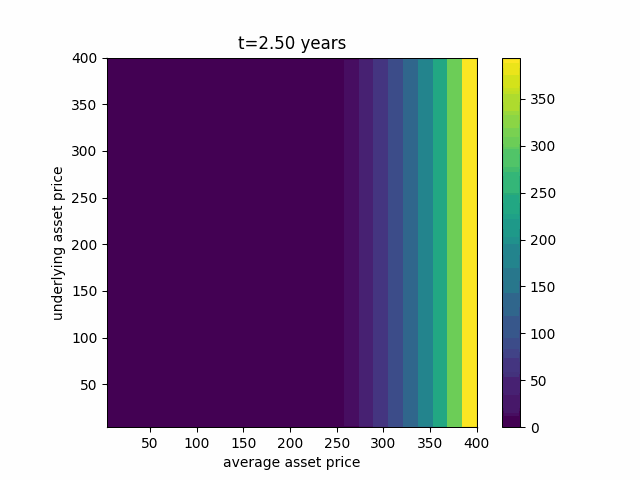

HTML(value="<a href='./tmpunetk5k6.gif' target='_blank'>./tmpunetk5k6.gif</a><br>")

In [14]:
progbar = IntProgress(max = simulation.nt+1)

def show_func2d_2(frame):
    progbar.value = frame
    fig, ax = pyplot.subplots()
    pyplot.title(f"t={settings.T - frame * simulation.dt:.2f} years")
    pyplot.imshow(
        history[frame],
        extent=(settings.S_min, settings.S_max, settings.S_min, settings.S_max),
        origin="lower"
    )
    pyplot.colorbar()
    annotate_axes(ax)
    return fig

display(progbar)
show_anim(show_func2d_2, range(simulation.nt+1), duration=0.01, loop=0)

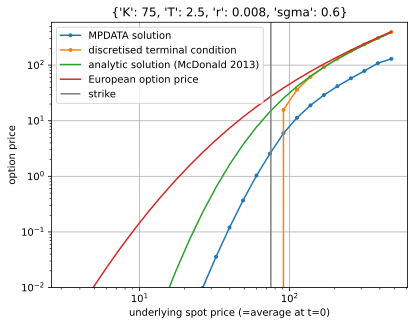

In [15]:
params = {
    'K': settings.K1,
    'T': settings.T,
    'r': settings.r,
    'sgma': settings.sigma,
}

frame = history[-1]
analytic_function = asian_analytic.geometric_asian_average_price_c
analytic = [
    analytic_function(
        S=spot,
        **params,
        dividend_yield=0
    ) for spot in simulation.S
]
pyplot.plot(simulation.S, frame.diagonal(), label="MPDATA solution", marker='.')
pyplot.plot(simulation.S, history[0].diagonal(), label="discretised terminal condition", marker='.')
pyplot.plot(simulation.S, analytic, label="analytic solution (McDonald 2013)")
pyplot.plot(simulation.S, Black_Scholes_1973.c_euro(S=simulation.S, **params, b=0), label="European option price")
pyplot.vlines(x=settings.K1, ymin=0, ymax=1e5, color='gray', label='strike')
pyplot.legend(loc='upper left')
pyplot.grid()
pyplot.ylim(0.01, 1.5 * np.amax(history[0]))
pyplot.title(f"{params}")
pyplot.xlabel("underlying spot price (=average at t=0)")
pyplot.ylabel("option price")
pyplot.xscale("log")
pyplot.yscale("log")
show_plot('numeric_vs_analytic.pdf')